<a href="https://colab.research.google.com/github/abhionair1/Autoencoder/blob/main/Time_series_forcasting_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [33]:
df = pd.read_csv('/content/monthly_milk_production.csv',index_col='Date',parse_dates=True)
df.index.freq='MS'

In [34]:
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


<Axes: xlabel='Date'>

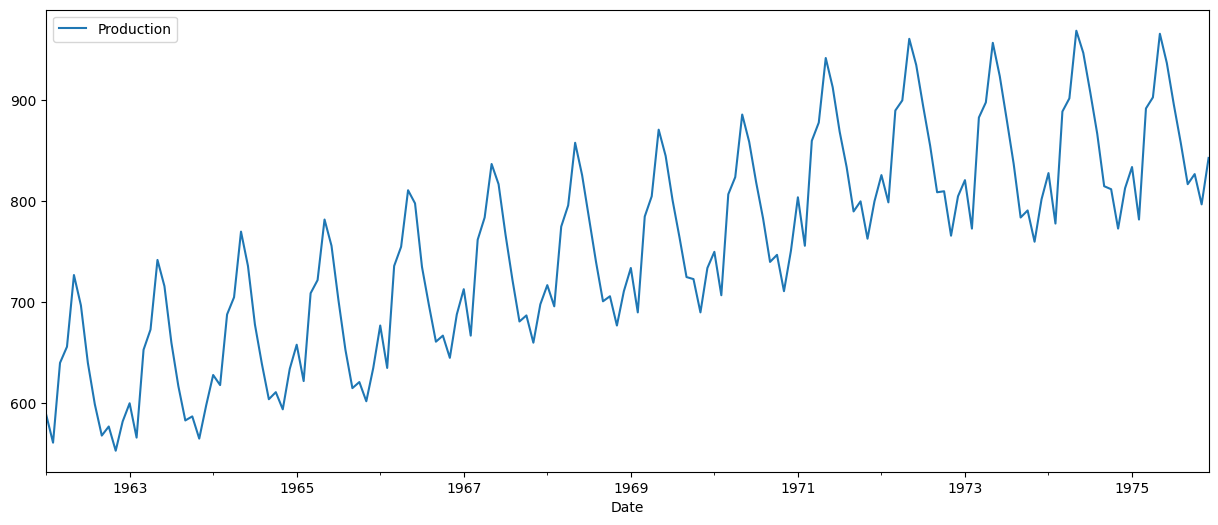

In [35]:
df.plot(figsize=(15,6))

In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose

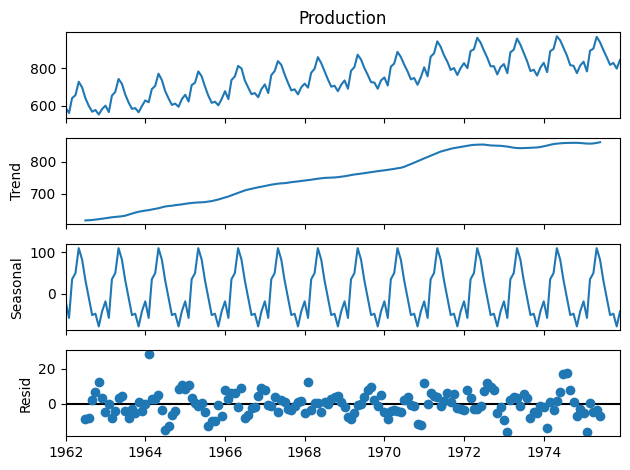

In [37]:
results = seasonal_decompose(df['Production'])
results.plot();

In [38]:

len(df)

168

In [39]:
test=df.iloc[156:]
test.shape

(12, 1)

In [40]:
train=df.iloc[:156]
train.shape


(156, 1)

In [41]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [42]:
df.head(),df.tail()

(            Production
 Date                  
 1962-01-01         589
 1962-02-01         561
 1962-03-01         640
 1962-04-01         656
 1962-05-01         727,
             Production
 Date                  
 1975-08-01         858
 1975-09-01         817
 1975-10-01         827
 1975-11-01         797
 1975-12-01         843)

In [43]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [44]:
scaled_train[:10]

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

In [45]:

from keras.preprocessing.sequence import TimeseriesGenerator

In [46]:

# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [47]:

X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.08653846 0.01923077 0.20913462]
Predict this y: 
 [[0.24759615]]


In [48]:
X.shape

(1, 3, 1)

In [49]:
X

array([[[0.08653846],
        [0.01923077],
        [0.20913462]]])

In [50]:
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [51]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [52]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [53]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [54]:
# fit model
model.fit(generator,epochs=30)

Epoch 1/30
144/144 [==============================] - 6s 22ms/step - loss: 0.0547
Epoch 2/30
144/144 [==============================] - 3s 24ms/step - loss: 0.0243
Epoch 3/30
144/144 [==============================] - 4s 27ms/step - loss: 0.0167
Epoch 4/30
144/144 [==============================] - 4s 28ms/step - loss: 0.0180
Epoch 5/30
144/144 [==============================] - 3s 23ms/step - loss: 0.0153
Epoch 6/30
144/144 [==============================] - 4s 31ms/step - loss: 0.0126
Epoch 7/30
144/144 [==============================] - 3s 23ms/step - loss: 0.0076
Epoch 8/30
144/144 [==============================] - 5s 31ms/step - loss: 0.0057
Epoch 9/30
144/144 [==============================] - 6s 43ms/step - loss: 0.0045
Epoch 10/30
144/144 [==============================] - 4s 26ms/step - loss: 0.0054
Epoch 11/30
144/144 [==============================] - 4s 26ms/step - loss: 0.0043
Epoch 12/30
144/144 [==============================] - 4s 31ms/step - loss: 0.0040
Epoch 13/30
1

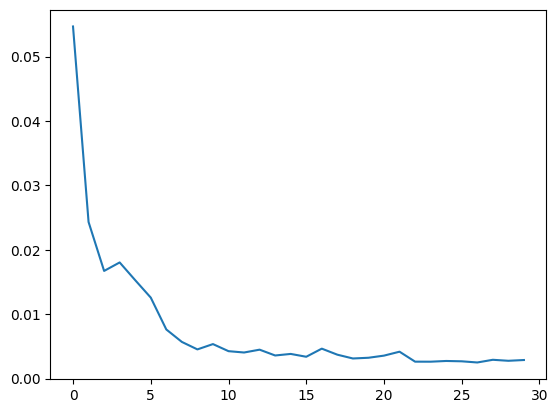

In [55]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [56]:
last_train_batch = scaled_train[-12:]

In [57]:
last_train_batch.shape

(12, 1)

In [58]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [59]:
last_train_batch.shape

(1, 12, 1)

In [60]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 179ms/step


array([[0.5949545]], dtype=float32)

In [61]:
scaled_test[0]

array([0.67548077])

In [62]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):

    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]

    # append the prediction into the array
    test_predictions.append(current_pred)

    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 23ms/step


In [63]:
test_predictions

[array([0.5949545], dtype=float32),
 array([0.5941513], dtype=float32),
 array([0.75890017], dtype=float32),
 array([0.8421703], dtype=float32),
 array([0.9229437], dtype=float32),
 array([0.91261524], dtype=float32),
 array([0.8482502], dtype=float32),
 array([0.73683804], dtype=float32),
 array([0.62040865], dtype=float32),
 array([0.56277865], dtype=float32),
 array([0.5217761], dtype=float32),
 array([0.53717846], dtype=float32)]

In [64]:
test.head()

,Production
Date,
1975-01-01,834
1975-02-01,782
1975-03-01,892
1975-04-01,903
1975-05-01,966


In [65]:
true_predictions = scaler.inverse_transform(test_predictions)

In [66]:
test['Predictions'] = true_predictions

<ipython-input-66-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<Axes: xlabel='Date'>

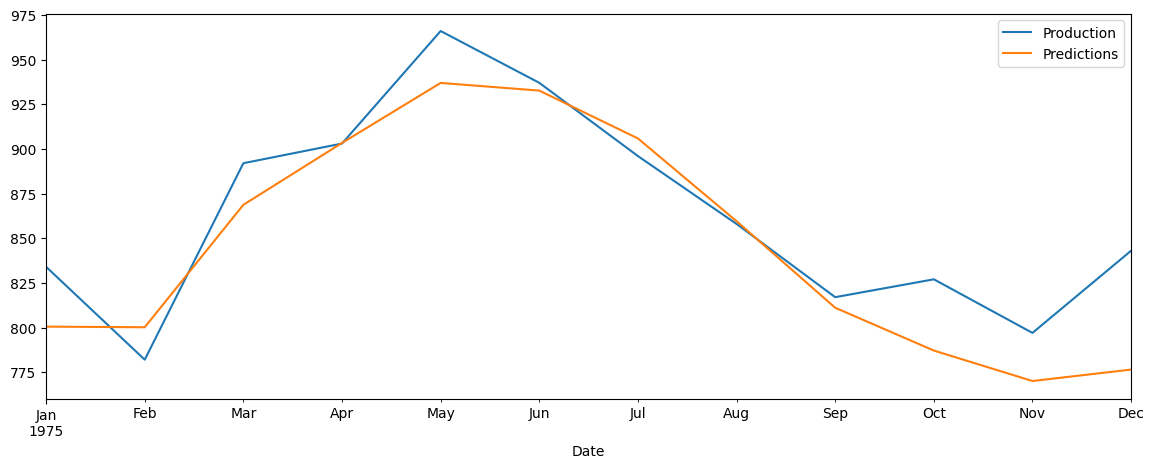

In [67]:
test.plot(figsize=(14,5))

In [68]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Production'],test['Predictions']))
print(rmse)

28.484329412472984
